# 6. Extracción de información y Visualización

En esta sección se realizará un análisis descriptivo de las diferentes fuentes de datos en alineación con los objetivos del proyecto definidos previamente.

Objetivo 1: Analizar la distribución de la población a nivel municipal, considerando variables demográficas como el tamaño poblacional y su estructura por grupos de edad.

Para este objetivo, representaremos tres visualizaciones en forma de mapa, usando los datos de población por municipio (INE):
Figura 1: Densidad de población por municipio (en escala logarítmica)
Figura 2: Densidad de población senior (+65) por municipio (en escala logarítmica)
Figura 3: Edad media aproximada de la población por municipio

Además, para visualizar la estructura por grupos de edad, haremos una comparativa entre las tres provincias, Valencia, Alicante y Castellón, del tamaño de cada grupo, mediante una gráfica de barras agrupadas:
Figura 4: Comparativa de tamaño de los grupos de edad por provincia.


## Objetivo 1: Analizar la distribución de la población a nivel municipal, considerando variables demográficas como el tamaño poblacional y su estructura por grupos de edad.

In [74]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import random

In [75]:
path = "../data/combined/centros_sanitarios_poblacion_municipios.csv"
df = pd.read_csv(path)

In [76]:
print(df.head())

   cod_provincia         provincia  cod_municipio    municipio  pob_100_mas  \
0              3  Alicante/Alacant           3001  Atzúbia, l'          0.0   
1              3  Alicante/Alacant           3002        Agost          1.0   
2              3  Alicante/Alacant           3003        Agres          0.0   
3              3  Alicante/Alacant           3004       Aigües          0.0   
4              3  Alicante/Alacant           3005     Albatera          0.0   

   pob_0_4  pob_10_14  pob_15_19  pob_20_24  pob_25_29  ...  pob_90_94  \
0     10.0       13.0       21.0       17.0       21.0  ...        8.0   
1    184.0      256.0      295.0      264.0      269.0  ...       68.0   
2     17.0       21.0       28.0       27.0       43.0  ...        7.0   
3     45.0       51.0       56.0       48.0       48.0  ...        2.0   
4    708.0      833.0      828.0      778.0      784.0  ...       93.0   

   pob_95_99  poblacion_total  \
0        1.0            601.0   
1       16.0  

### 6.1 Densidad de población por municipio (en escala logarítmica)


In [77]:
df_unique = df.drop_duplicates(subset="cod_municipio", keep="first").copy()
print(len(df))
print(len(df_unique))

682
542


In [78]:
# Calculamos la densidad de población de cada municipio
df_unique["density"] = df_unique["poblacion_total"] / df_unique["area_ha"]
df_unique["geometry"] = df_unique["geometry_municipio"].apply(wkt.loads)

In [79]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

Representamos la densidad de población en escala logarítmica para facilitar la interpretación de las diferencias entre municipios.

In [80]:
gdf["log_density"] = np.log10(gdf["density"] + 1)

In [81]:
# Creamos un polígono por provincia
gdf_prov = gdf.dissolve(by="provincia")

# Calculamos centroides para escribir los nombres de provincias
gdf_prov["label_point"] = gdf_prov.geometry.representative_point()

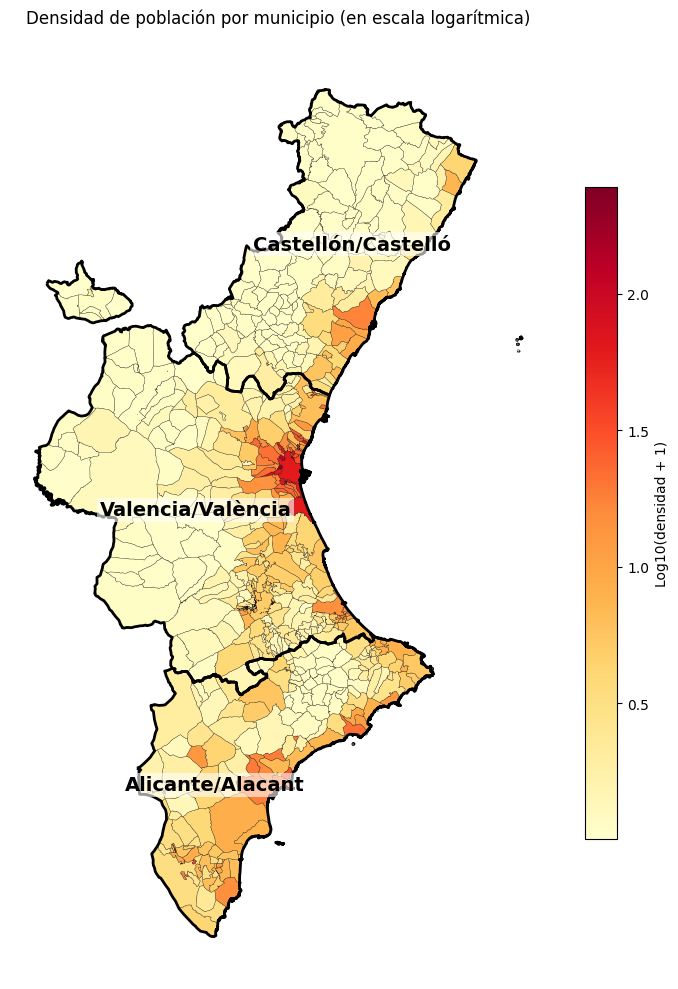

In [82]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )

ax.set_aspect("equal")
ax.set_title("Densidad de población por municipio (en escala logarítmica)")
ax.set_axis_off()

plt.tight_layout()

plt.savefig("../graficas/densidad_poblacion_por_municipio.pdf", bbox_inches="tight")

plt.show()

Observaciones: Las zonas de mayor densidad de población tienden a concentrarse en la zona de la costa, mientras que en el interior hay muchos municipios con menor densidad en la escala logarítmica. La mayor densidad se localiza alrededor de la ciudad de Valencia.

###  6.2 Densidad de población senior (+65) por municipio (en escala logarítmica)


In [83]:
cols_65 = [
    "pob_65_69",
    "pob_70_74",
    "pob_75_79",
    "pob_80_84",
    "pob_85_89",
    "pob_90_94",
    "pob_95_99"
]

df_unique["poblacion_65_mas"] = df_unique[cols_65].sum(axis=1)
df_unique["density_65"] = df_unique["poblacion_65_mas"] / df_unique["area_ha"]

In [84]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")
gdf["log_density_65"] = np.log10(gdf["density_65"] + 1)

# Creamos un polígono por provincia
gdf_prov = gdf.dissolve(by="provincia")

# Calculamos centroides para escribir los nombres de provincias
gdf_prov["label_point"] = gdf_prov.geometry.representative_point()

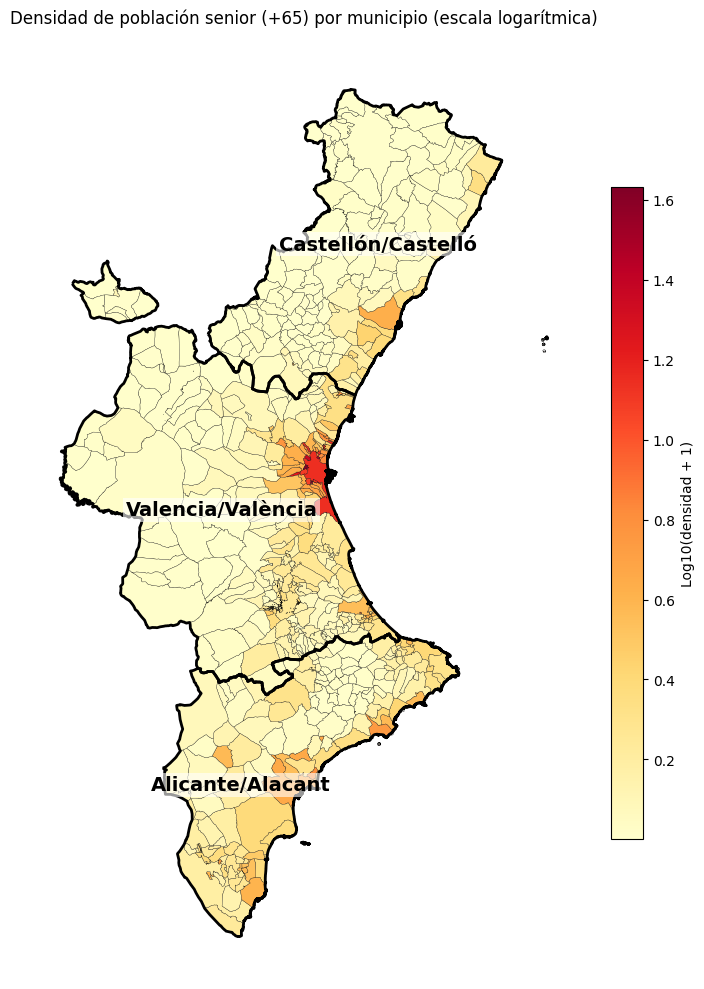

In [85]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density_65",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )

ax.set_aspect("equal")
ax.set_title("Densidad de población senior (+65) por municipio (escala logarítmica)")
ax.set_axis_off()

plt.tight_layout()

plt.savefig("../graficas/densidad_poblacion_senior_por_municipio.pdf", bbox_inches="tight")

plt.show()

###  6. 3 Edad media aproximada de la población por municipio

In [86]:
age_bins = {
    "pob_0_4": 2.5,
    "pob_5_9": 7.5,
    "pob_10_14": 12.5,
    "pob_15_19": 17.5,
    "pob_20_24": 22.5,
    "pob_25_29": 27.5,
    "pob_30_34": 32.5,
    "pob_35_39": 37.5,
    "pob_40_44": 42.5,
    "pob_45_49": 47.5,
    "pob_50_54": 52.5,
    "pob_55_59": 57.5,
    "pob_60_64": 62.5,
    "pob_65_69": 67.5,
    "pob_70_74": 72.5,
    "pob_75_79": 77.5,
    "pob_80_84": 82.5,
    "pob_85_89": 87.5,
    "pob_90_94": 92.5,
    "pob_95_99": 97.5
}


In [87]:
missing = set(age_bins.keys()) - set(df_unique.columns)
print("Missing columns:", missing)


Missing columns: set()


In [88]:
weighted_sum = sum(df_unique[col] * mid for col, mid in age_bins.items())
total_pop = df_unique[list(age_bins.keys())].sum(axis=1)

df_unique["edad_media"] = weighted_sum / total_pop.replace(0, np.nan)

In [89]:
df_unique[["municipio", "edad_media"]].head()

,municipio,edad_media
0,"Atzúbia, l'",54.846090
1,Agost,44.875072
2,Agres,47.916000
3,Aigües,44.762005
4,Albatera,40.703844


In [90]:
gdf = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

# Creamos un polígono por provincia
gdf_prov = gdf.dissolve(by="provincia")

# Calculamos centroides para escribir los nombres de provincias
gdf_prov["label_point"] = gdf_prov.geometry.representative_point()

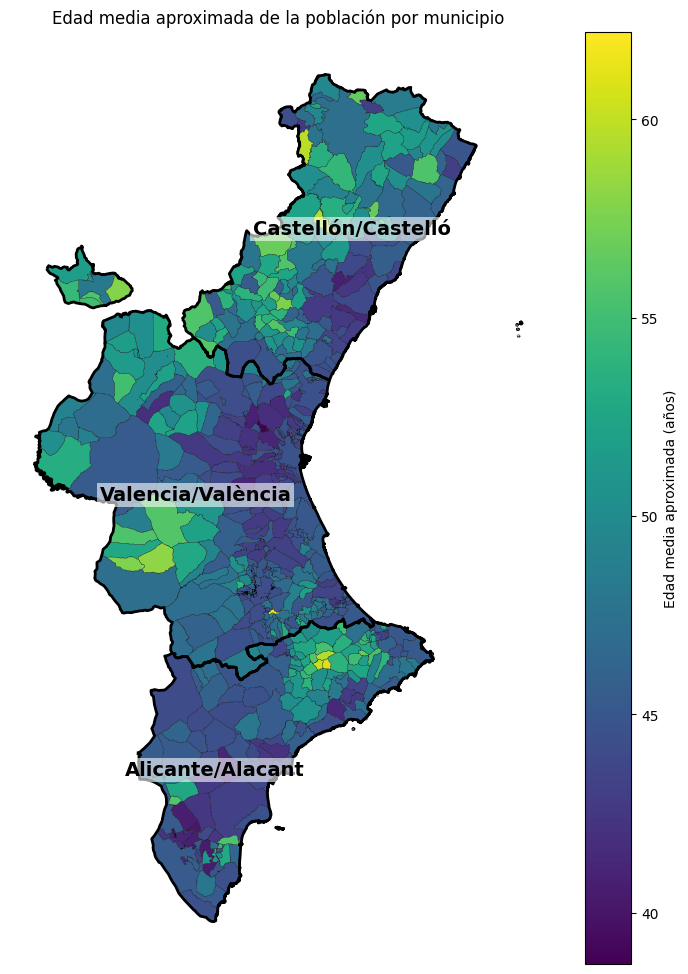

In [91]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="edad_media",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={"label": "Edad media aproximada (años)"}
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )

ax.set_aspect("equal")
ax.set_title("Edad media aproximada de la población por municipio")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../graficas/edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


Observaciones: Los municipios donde más densidad de población hay (Figura 1) no se corresponden con los municipios donde la media de la edad es mayor (Figura 3). Nos interesa detectar cuáles son esos municipios donde hay más personas mayores en proporción (municipios en verde claro en la Figura 3). Para ello, obtenemos el 10% de los municipios que tienen mayor edad media (calculamos el percentil 90 y obtenemos los municipios por encima de este valor). Escribiremos los nombres de dichos municipios en el mapa.

### 6.4 Edad media aproximada de la población por municipio (con el top 3% de los municipios con mayor edad media numerados en el mapa)

In [92]:
q90_edad = gdf["edad_media"].quantile(0.95)
q90_edad 

55.235355536157925

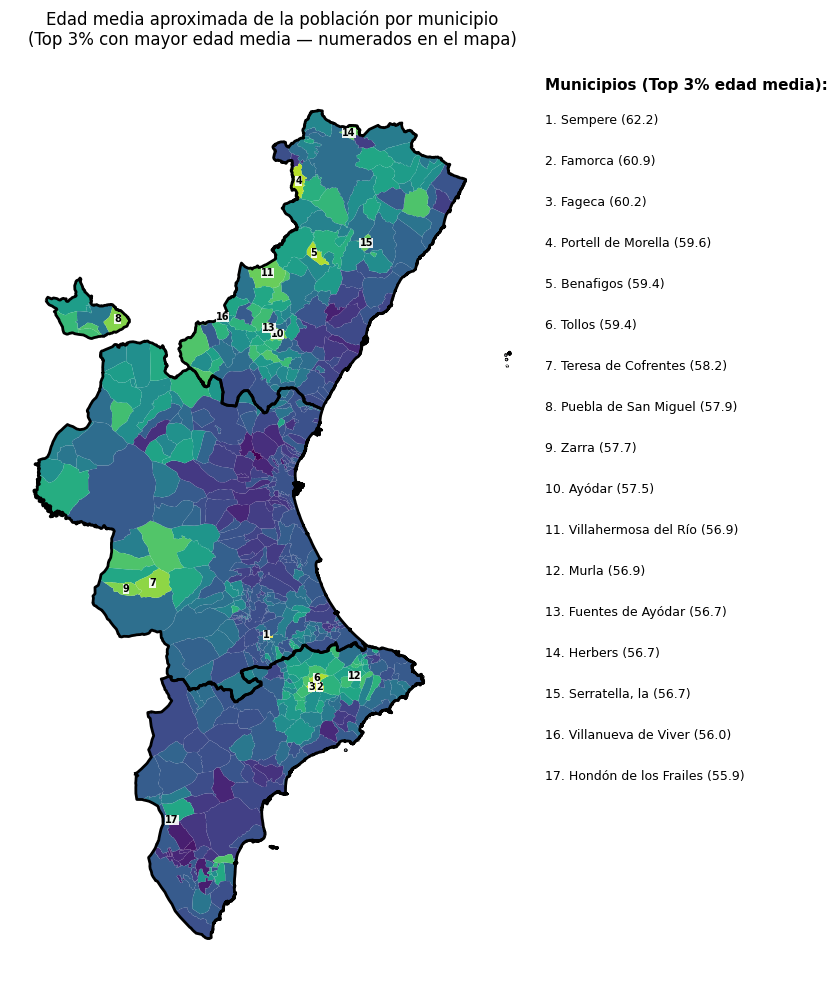

In [93]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))  # a bit wider for side list

gdf.plot(
    column="edad_media",
    cmap="viridis",
    legend=False,
    ax=ax
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

q97 = gdf["edad_media"].quantile(0.97)
gdf_top3 = gdf[gdf["edad_media"] >= q97].copy()
gdf_top3["label_point"] = gdf_top3.geometry.representative_point()

gdf_top3 = gdf_top3.sort_values("edad_media", ascending=False).reset_index(drop=True)

for i, row in gdf_top3.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y

    ax.text(
        x, y,
        str(i + 1),
        fontsize=7,
        fontweight="bold",
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.9, edgecolor="None", pad=0)
    )

text_x = 1.02   # fuera del eje
text_y = 0.95
line_h = 0.045

ax.text(
    1.02, 0.99,
    "Municipios (Top 3% edad media):",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    va="top"
)

for i, row in gdf_top3.iterrows():
    label = f"{i+1}. {row['municipio']} ({row['edad_media']:.1f})"
    ax.text(
        text_x,
        text_y - i * line_h,
        label,
        transform=ax.transAxes,
        fontsize=9,
        va="top"
    )

ax.set_aspect("equal")
ax.set_title(
    "Edad media aproximada de la población por municipio\n"
    "(Top 3% con mayor edad media — numerados en el mapa)"
)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../graficas/edad_media_municipios_top3.pdf", bbox_inches="tight")
plt.show()



Observaciones: En este mapa ya vemos claramente cuáles son los municipios con mayor proporción de personas mayores (el 3% con mayor proporción): Sempere con una edad media de 62,2 años, Famorca con 60,9, etc.

### 6.5 Comparativa de las proporciones de los grupos de edad por provincia

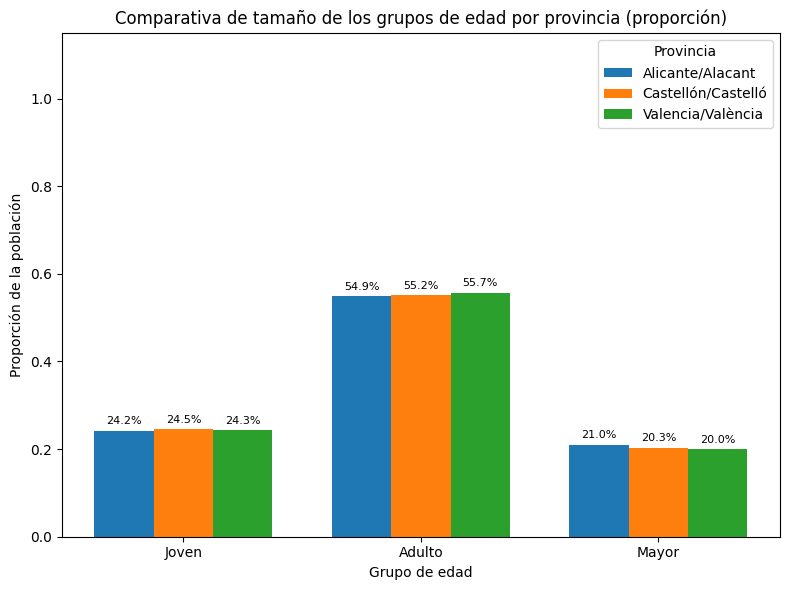

In [94]:
joven_cols = ["pob_0_4","pob_5_9","pob_10_14","pob_15_19", "pob_20_24"]
adulto_cols = ["pob_25_29","pob_30_34","pob_35_39",
               "pob_40_44","pob_45_49","pob_50_54","pob_55_59","pob_60_64"]
mayor_cols = ["pob_65_69","pob_70_74","pob_75_79","pob_80_84",
              "pob_85_89","pob_90_94","pob_95_99","pob_100_mas"]

num_cols = joven_cols + adulto_cols + mayor_cols + ["poblacion_total"]
df_num = gdf[["provincia"] + num_cols]

prov_age = df_num.groupby("provincia").sum()

prov_age["Joven"] = prov_age[joven_cols].sum(axis=1)
prov_age["Adulto"] = prov_age[adulto_cols].sum(axis=1)
prov_age["Mayor"] = prov_age[mayor_cols].sum(axis=1)

prov_age["Joven"] /= prov_age["poblacion_total"]
prov_age["Adulto"] /= prov_age["poblacion_total"]
prov_age["Mayor"] /= prov_age["poblacion_total"]

age_groups = ["Joven", "Adulto", "Mayor"]
provincias = prov_age.index.tolist()

x = np.arange(len(age_groups))  # posiciones de grupos de edad
bar_width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # un color por provincia


for i, prov in enumerate(provincias):
    heights = prov_age.loc[prov, age_groups]
    bars = ax.bar(x + i*bar_width, heights, width=bar_width, color=colors[i], label=prov)
    
    for bar, h in zip(bars, heights):
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            h + 0.01,                        
            f"{h*100:.1f}%",                  
            ha="center",
            va="bottom",
            fontsize=8
        )


ax.set_xticks(x + bar_width*(len(provincias)-1)/2)
ax.set_xticklabels(age_groups)
ax.set_ylabel("Proporción de la población")
ax.set_xlabel("Grupo de edad")
ax.set_title("Comparativa de tamaño de los grupos de edad por provincia (proporción)")
ax.legend(title="Provincia")
ax.set_ylim(0, 1.15)  # un poco más alto para que los textos no se corten
plt.tight_layout()
plt.savefig("../graficas/proporciones_grupos_edad_provincia.pdf", bbox_inches="tight")
plt.show()


Observaciones: La gráfica obtenida nos da información sobre la proporción de cada grupo de edad, pero no nos permite visualizar bien las diferencias entre provincias, ya que todas tienen proporciones similares (un dato que era de esperar, pero hemos confirmado gracias a la gráfica). Las etiquetas con los porcentajes nos permiten compara mejor: Alicante es la provincia con mayor población mayor, seguida de Castellón.

## Objetivo 2: Estudiar la distribución territorial de los centros sanitarios (hospitales, centros de especialidades y centros de salud) en el ámbito de la Comunitat Valenciana.

###  6.6 Presencia de centros sanitarios y densidad de población por municipio

In [95]:
df_unique["tiene_centro_sanitario"].isna().sum()

0

In [96]:
gdf["rep_point"] = gdf.geometry.representative_point()

In [97]:
gdf_centros = gdf[gdf["tiene_centro_sanitario"] == 1]
gdf["log_density"] = np.log10(gdf["density"] + 1)

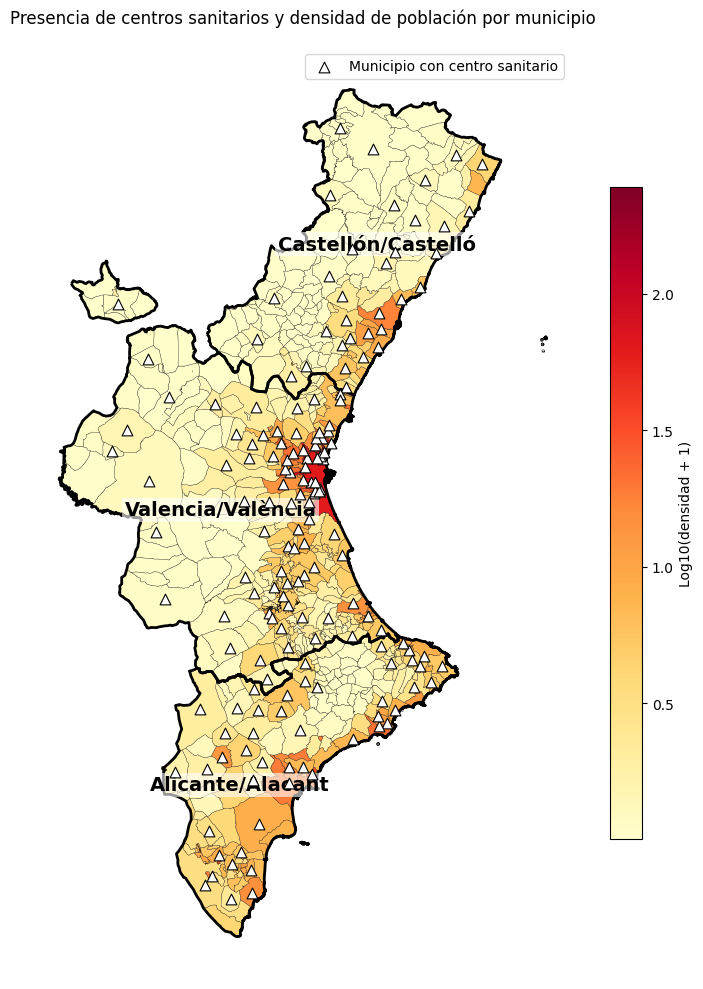

In [98]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",           
    s=60,                 
    facecolors="white",   
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

ax.set_aspect("equal")
ax.set_title("Presencia de centros sanitarios y densidad de población por municipio")
ax.set_axis_off()

ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("../graficas/centros_densidad_poblacion_por_municipio.pdf", bbox_inches="tight")
plt.show()


Observaciones: Podemos ver que en las zonas menos pobladas hay muchos municipios sin centro sanitario. Esto podría ser un problema si esos municipios, a pesar de tener poca población, tienen una proporción mayor de personas mayores. Por ello generamos la siguiente visualización. 

###  6.7 Presencia de centros sanitarios y edad media aproximada por municipio

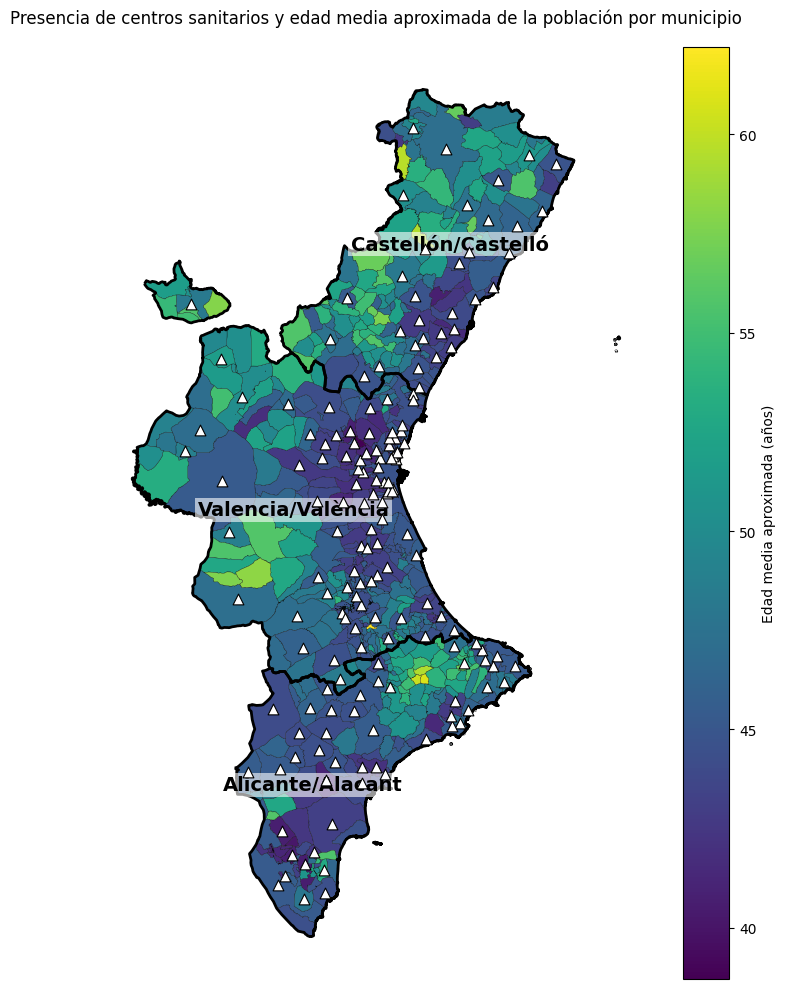

In [99]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="edad_media",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={"label": "Edad media aproximada (años)"}
)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )
    
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",           # triangle
    s=60,                 # size
    facecolors="white",   # visible on dark areas
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

ax.set_aspect("equal")
ax.set_title("Presencia de centros sanitarios y edad media aproximada de la población por municipio")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../graficas/centros_edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


Observaciones: Efectivamente, muchas de las zonas despobladas sin centros de salud corresponden con municipios donde la edad media es bastante alta. Esto podría indicarnos un problema de falta de atención sanitaria en algunos municipios.

###  6.8 Bubble chart de la edad media vs. cantidad de centros sanitarios

In [100]:
hc_count = df.groupby("cod_municipio")["cen_cod"].count().reset_index()
hc_count.rename(columns={"cen_cod": "num_centros"}, inplace=True)

# Inspect
hc_count.head()

,cod_municipio,num_centros
0,3001,0
1,3002,1
2,3003,0
3,3004,0
4,3005,1


In [101]:
df_bubble = df_unique.merge(hc_count, on="cod_municipio", how="left")

# Fill municipios with 0 health centers (if none)
df_bubble["num_centros"] = df_bubble["num_centros"].fillna(0)

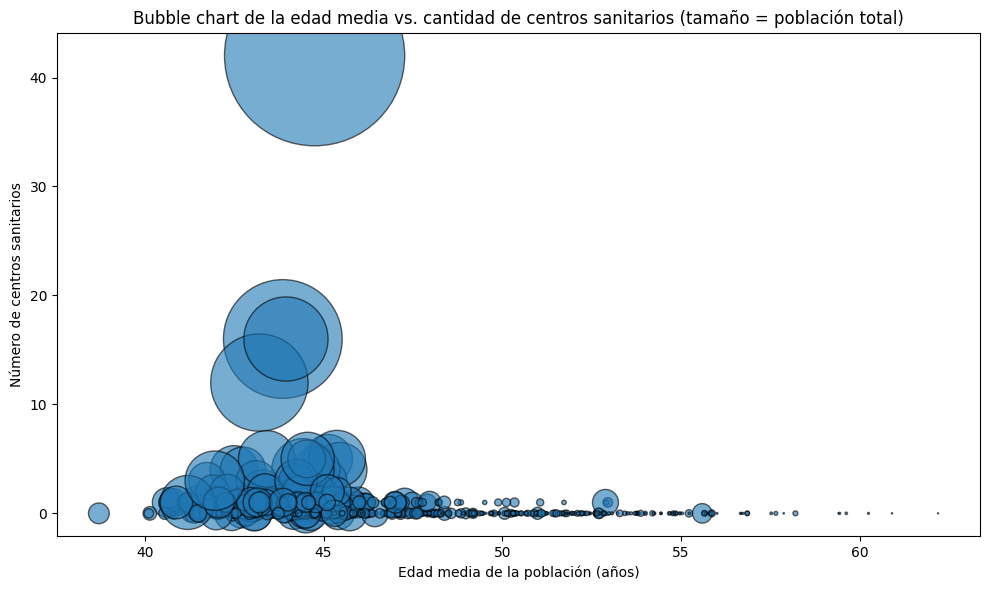

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    x=df_bubble["edad_media"],
    y=df_bubble["num_centros"],
    s=df_bubble["poblacion_total"] / 50,  # scale bubble sizes for visibility
    alpha=0.6,
    edgecolors="black"
)

ax.set_xlabel("Edad media de la población (años)")
ax.set_ylabel("Número de centros sanitarios")
ax.set_title("Bubble chart de la edad media vs. cantidad de centros sanitarios (tamaño = población total)")

plt.tight_layout()
plt.savefig("../graficas/bubblechart_edad_media_municipios.pdf", bbox_inches="tight")
plt.show()


Observaciones: Efectivamente, vemos en el bubble chart que los municipios donde la edad media aproximada es mayor son municipios donde no hay centros de salud. Los municipios donde más centros de salud hay son los municipios con mayor densidad de población, que además tienen una edad media alrededor de los 44-45 años.

###  6.7 Mapa de municipios de riesgo de falta de atención sanitaria

In [103]:
df_unique["geometry"] = df_unique["geometry_municipio"].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

gdf_all = gpd.GeoDataFrame(df_unique, geometry="geometry", crs="EPSG:4326")

hc_count = df.groupby("cod_municipio")["cen_cod"].count().reset_index()
hc_count.rename(columns={"cen_cod": "num_centros"}, inplace=True)

gdf_all = gdf_all.merge(hc_count, on="cod_municipio", how="left")
gdf_all["num_centros"] = gdf_all["num_centros"].fillna(0)

gdf_all["risk"] = (gdf_all["edad_media"] > 45) & (gdf_all["num_centros"] == 0)

gdf_risk = gdf_all[gdf_all["risk"]].copy()
gdf_risk = gdf_risk.reset_index(drop=True)
gdf_risk["label_num"] = range(1, len(gdf_risk) + 1)

gdf_risk["rep_point"] = gdf_risk.geometry.representative_point()

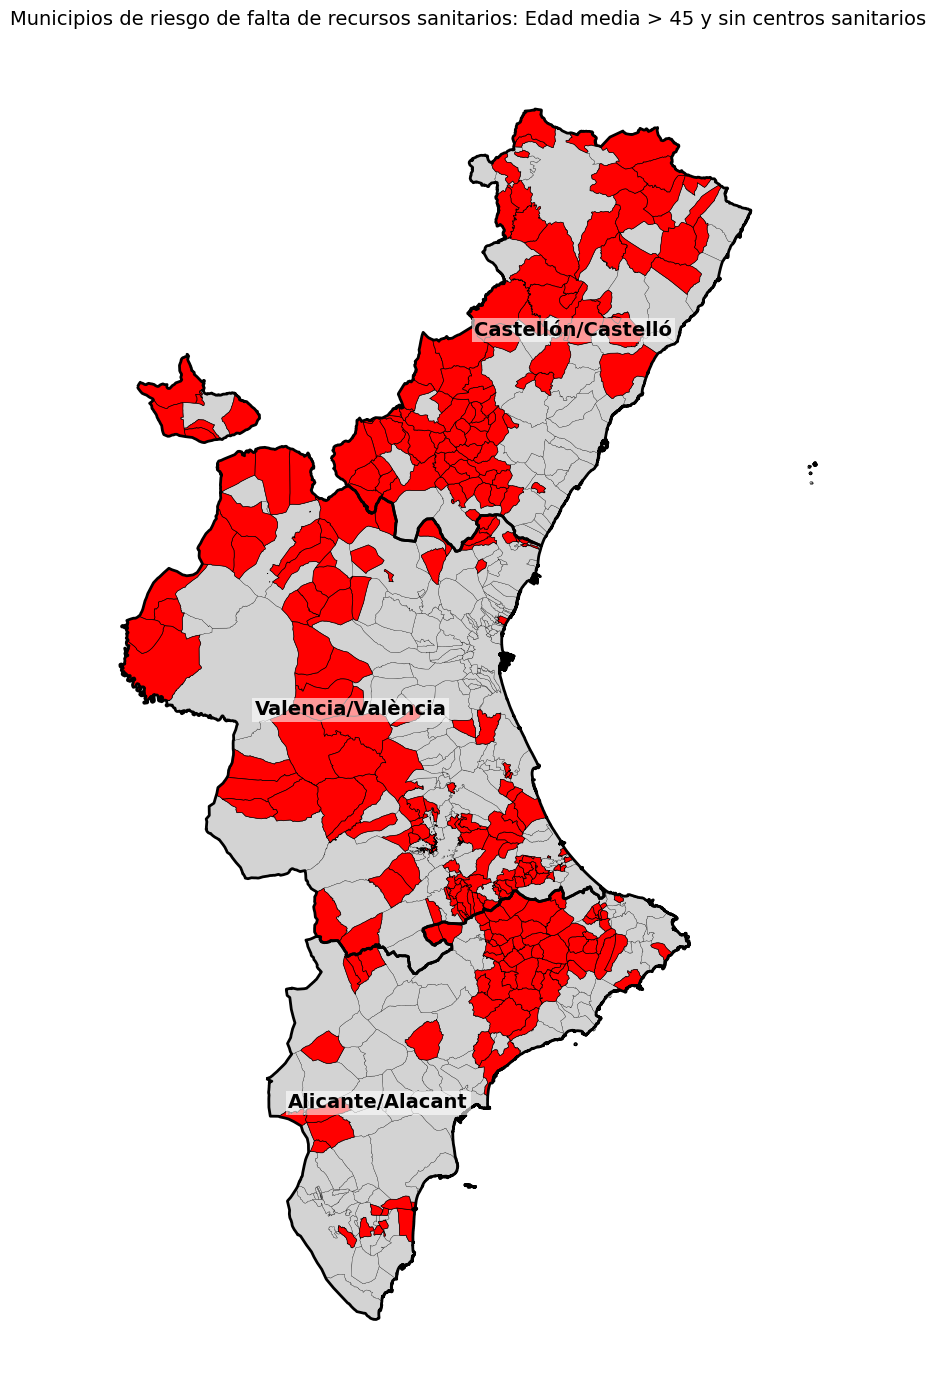

In [104]:
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(12, 14))

gdf_all.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.2)

gdf_risk.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)

gdf_prov.boundary.plot(
    ax=ax,
    color="black",
    linewidth=2
)

for idx, row in gdf_prov.iterrows():
    x = row["label_point"].x
    y = row["label_point"].y
    ax.text(
        x, y, idx,
        ha="center", va="center",
        fontsize=14,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=2)
    )
    
ax.set_aspect("equal")
ax.set_axis_off()
ax.set_title("Municipios de riesgo de falta de recursos sanitarios: Edad media > 45 y sin centros sanitarios", fontsize=14)

plt.tight_layout()
plt.savefig("../graficas/municipios_riesgo.pdf", bbox_inches="tight")
plt.show()


Lista con los nombres de los municipios de riesgo:

In [105]:
legend_list = gdf_risk[["label_num", "municipio"]].sort_values("label_num")

# Convert to a list of names
names = legend_list["municipio"].tolist()

# Print all in one line, separated by commas
print(", ".join(names))


Atzúbia, l', Agres, Alcalalí, Alcosser, Alcoleja, Alfafara, Algorfa, Algueña, Almudaina, Balones, Benasau, Beneixama, Beniardà, Beniarrés, Benigembla, Benidoleig, Benifallim, Benifato, Benijófar, Benillup, Benimantell, Benimarfull, Benimassot, Benimeli, Poble Nou de Benitatxell, el/Benitachell, Bolulla, Busot, Calp, Campello, el, Camp de Mirra, el/Campo de Mirra, Cañada, Castell de Castells, Confrides, Quatretondeta, Daya Nueva, Daya Vieja, Fageca, Famorca, Gaianes, Gorga, Castell de Guadalest, el, Guardamar del Segura, Fondó de les Neus, el/Hondón de las Nieves, Hondón de los Frailes, Jacarilla, Xaló, Orxa, l'/Lorcha, Llíber, Millena, Murla, Orxeta, Parcent, Penàguila, Planes, Ràfol d'Almúnia, el, Relleu, Romana, la, Sagra, Salinas, Sanet y Negrals, San Fulgencio, Sella, Tàrbena, Tibi, Tollos, Tormos, Torre de les Maçanes, la/Torremanzanas, Vall d'Alcalà, la, Vall d'Ebo, la, Vall de Gallinera, la, Vall de Laguar, la, Poblets, els, Aín, Alcudia de Veo, Alfondeguilla, Algimia de Almonac